In [1]:
# Import necessary packages. Installation in the environment must happen before. Requirements .txt not available yet.
import pandas as pd
import gdelt
import datetime
import time
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


########################## GDELT API data loader

def c2arp_crawler(start_date, end_date, country):
    # Create GDELT API connection
    gd2 = gdelt.gdelt(version=2)

    df_iso = pd.read_csv("iso3166.csv", delimiter=';')
    country_3 = df_iso.loc[df_iso['Name'] == country, 'Code'].values[0]
    
    # Convert start and end date strings to datetime objects
    start_datetime = datetime.datetime.strptime(start_date, '%Y %m %d')
    end_datetime = datetime.datetime.strptime(end_date, '%Y %m %d')

    # Calculate the number of days between start and end dates
    delta = end_datetime - start_datetime
    num_days = delta.days + 1  # Include the end date

    print(f"Starting download for {country_3} for {num_days} days now...")
 
    # Initialize time measurement
    start_time = time.time()
    
    for i in range(num_days):
        # Calculate the current date in the loop
        current_date = start_datetime + datetime.timedelta(days=i)
        current_date_str = current_date.strftime('%Y %m %d')

        try:
            # Perform the GDELT search for the current date
            df = gd2.Search([current_date_str], table='events', coverage=True)

            results_filtered = df[
                (df['Actor1CountryCode'] == country_3) |
                (df['Actor2CountryCode'] == country_3) |
                (df['ActionGeo_FullName'].str.contains(country, na=False))
            ]

            # Load the existing CSV file or create a new DataFrame
            try:
                all_results = pd.read_csv(f'{country_3} {start_date} - {end_date}.csv', parse_dates=['SQLDATE'], low_memory=False)
            except FileNotFoundError:
                all_results = pd.DataFrame(columns=results_filtered.columns)

            # Concatenate the filtered results to the existing DataFrame
            all_results = pd.concat([all_results, results_filtered])

            # Save the DataFrame to a CSV file
            all_results.to_csv(f'{country_3} {start_date} - {end_date}.csv', index=False)

            # Print progress information
            elapsed_time = time.time() - start_time
            print(f"Processed date: {current_date_str}, {i+1}/{num_days} days done. Time taken = {elapsed_time:.2f} seconds")
            
            # Reset timer
            start_time = time.time()

        except Exception as e:
            # Handle exceptions and continue to the next date
            print(f"Error processing date {current_date_str}: {e}")
            continue

def c2arp_actors(file, country):
    # Load the previous collected datafile
    df = pd.read_csv(file, low_memory=False)
    
    # Identify each actor on country level
    actors1 = df['Actor1CountryCode'].unique().tolist()
    actors2 = df['Actor2CountryCode'].unique().tolist()
    
    # Combine the lists and remove duplicates
    actors = list(set(actors1 + actors2))
    
    # Remove the assessed country if it exists in the list
    if country in actors:
        actors.remove(country)
        
    # Create a DataFrame of all actor nations
    df_act = pd.DataFrame(actors, columns=["Actors"])
    
    # Add columns for QCto and QCfrom for each QuadClass
    for qc in range(1, 5):
        df_act[f"QC{qc}to"] = 0
        df_act[f"QC{qc}from"] = 0
    
    # Calculate QCto and QCfrom for each QuadClass for each actor
    for index, actor in df_act.iterrows():
        for qc in range(1, 5):
            # Count entries where actor is in Actor2CountryCode, country is in Actor1CountryCode, and QuadClass is qc
            qc_to_count = df[(df['Actor2CountryCode'] == actor['Actors']) & 
                             (df['Actor1CountryCode'] == country) & 
                             (df['QuadClass'] == qc)].shape[0]
            
            # Count entries where actor is in Actor1CountryCode, country is in Actor2CountryCode, and QuadClass is qc
            qc_from_count = df[(df['Actor1CountryCode'] == actor['Actors']) & 
                               (df['Actor2CountryCode'] == country) & 
                               (df['QuadClass'] == qc)].shape[0]
            
            # Update the respective columns
            df_act.at[index, f"QC{qc}to"] = qc_to_count
            df_act.at[index, f"QC{qc}from"] = qc_from_count
    
    # Calculate GS for each actor
    df_act["GS"] = 0
    for index, actor in df_act.iterrows():
        gs_sum = 0
        for qc in range(1, 5):
            # Sum GoldsteinScale values where conditions are met
            gs_sum += df[(df['Actor2CountryCode'] == actor['Actors']) & 
                         (df['Actor1CountryCode'] == country) & 
                         (df['QuadClass'] == qc)]['GoldsteinScale'].sum()
            gs_sum += df[(df['Actor1CountryCode'] == actor['Actors']) & 
                         (df['Actor2CountryCode'] == country) & 
                         (df['QuadClass'] == qc)]['GoldsteinScale'].sum()
        
        # Update the GS column
        df_act.at[index, "GS"] = gs_sum
    
    # Calculate the sum of "QCTo" and "QCFrom" for each actor
    df_act["EventSum"] = df_act[[f'QC{qc}to' for qc in range(1, 5)]].sum(axis=1) + df_act[[f'QC{qc}from' for qc in range(1, 5)]].sum(axis=1)
    
    
    df_act.to_csv(f"{country}_actors.csv")
    print("Actor analysis complete!")

def c2arp_actors_viz(file, country, start_date, end_date):
    start_date = start_date.replace(' ', '-')
    end_date = end_date.replace(' ', '-')
    daterange = start_date + ' to ' + end_date
    # Load the actors data
    df_act = pd.read_csv(file, low_memory=False, index_col=1)
    iso = pd.read_csv("iso3166.csv", sep=";")

    # Sort the DataFrame by the value in "EventSum"
    df_act_sorted = df_act.sort_values(by="EventSum", ascending=False)
    
    # Select the top 10 entries
    df_act_top10 = df_act_sorted.head(10)

    # Set up colors for QuadClasses using a modern palette
    colors = ['#D32F2F', '#F57C00', '#388E3C', '#4CAF50']
    quad_classes = ['QC4', 'QC3', 'QC2', 'QC1']
    descriptions = ['Material Conflict Action', 'Verbal Conflict Action', 'Material Cooperation Action', 'Verbal Cooperation Action']

    # Get full names from ISO dataset
    actor_names = df_act_top10.index.to_series().map(iso.set_index('Code')['Name'])
    country_name = iso[iso['Code'] == country]['Name'].values[0]
    
    # Logarithmic scaling for QuadClasses
    df_act_scaled = np.log1p(df_act_top10.drop(columns=['GS']))
    
    # Scale GS score between -10 and 10
    max_abs_gs = np.max(np.abs(df_act_top10['GS']))
    gs_scaled = (20 * df_act_top10['GS'] / max_abs_gs) if max_abs_gs != 0 else 0
    
    # Ensure positive values remain positive and negative values remain negative
    gs_scaled = np.clip(gs_scaled, -10, 10)
    
    # Plotting
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='#002040')
    ax.set_facecolor('#002040')

    for i, actor in enumerate(df_act_scaled.index):
        # Calculate positions for bars
        y_pos = i
        total_width = np.sum(df_act_scaled.loc[actor])
        x_pos_left = 0  # Starting position for left bars
        x_pos_right = 0  # Starting position for right bars
        
        # Plot bars for QuadClasses
        for j, qc in enumerate(quad_classes):
            w_to = df_act_scaled.loc[actor, f'{qc}to']
            w_from = df_act_scaled.loc[actor, f'{qc}from']
            
            # Plot "to" bar to the right of the centerline
            ax.barh(y_pos, w_to, left=x_pos_right, color=colors[j], alpha=1, linewidth=0)
            x_pos_right += w_to
            
            # Plot "from" bar to the left of the centerline
            x_pos_left = x_pos_left - w_from
            ax.barh(y_pos, w_from, left=x_pos_left, color=colors[j], alpha=1, linewidth=0)

        # Plot GS score as a marker
        ax.scatter(gs_scaled.loc[actor], y_pos, color='gold', marker='|', s=500, label=None if i > 0 else 'Goldstein Scale (scaled)')

    # Add centerline
    ax.axvline(0, color='white', linewidth=1.5)

    # Add labels
    ax.set_yticks(range(10))
    ax.set_yticklabels(actor_names, fontname='Arial', fontsize=12, color='white')
    ax.set_xlabel('Logarithmic Event Sum', fontsize=12, fontname='Arial', color='white')
    ax.set_title(f'{country_name}\'s Top 10 International Relations from {daterange}\n\nAction towards {country_name}{" " * 30}Action from {country_name}', fontsize=14, fontname='Arial', color='white')

    ax.invert_yaxis()  # Invert y-axis to have the first actor at the top

    # Hide spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Tone down grid lines
    ax.grid(color='white', linestyle='-', linewidth=0.3)
    ax.xaxis.grid(True)
    ax.yaxis.grid(False)

    # Remove x-axis ticks
    ax.tick_params(axis='x', which='both', bottom=False, top=False, colors='white')
    ax.tick_params(axis='y', which='both', left=False, right=False)

   # Add legend with descriptions
    patches = [plt.Rectangle((0,0),1,1, color=colors[i], ec="none") for i in range(len(colors))]
    descriptions_with_gs = descriptions + ['Scaled Cumulative Goldstein Score']
    descriptions_with_gs_full = ['Actions of physical disagreement', 
                                 'Actions of verbal disagreement', 
                                 'Actions of physical cooperation', 
                                 'Actions of verbal cooperation'] + ['Scaled Cumulative Goldstein Score\nindicating the overall impact']
    patches.append(plt.Line2D([0], [0], marker='|', color='gold', markersize=10, linestyle='None', label='Goldstein Scale (scaled)'))
    legend = ax.legend(patches, descriptions_with_gs_full, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, labelcolor='white', facecolor='#002040')

    for text in legend.get_texts():
        text.set_color("white")
        text.set_ha('left')

    # Add license and data source box
    cr = "\u00A9"
    license_text = ("Analysis created with C²ARP\n"
                    f"{cr} 2024 Swes92 / The C²ARP Project under GNU GPL 3.0\n"
                    "Data Source: The GDELT Project (https://www.gdeltproject.org/)\n"
                    "Visualization: Matplotlib & Seaborn\n"
                    "Image licensed under CC BY-SA 4.0\n"
                    )
    plt.figtext(0.99, 0.01, license_text, horizontalalignment='right', fontsize=8, color='white')

    # Set equal limits for the x-axis
    ax.set_xlim(-max(ax.get_xlim()[1], abs(ax.get_xlim()[0])), max(ax.get_xlim()[1], abs(ax.get_xlim()[0])))

    # Show plot
    plt.tight_layout()
    plt.show()



here


In [ ]:
c2arp_crawler('2024 04 01', '2024 04 30', 'India')

In [ ]:
c2arp_actors("IND_test.csv", 'IND')

In [ ]:
c2arp_actors_viz("IND_actors.csv", 'IND', '2024 04 01', '2024 04 30')

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader


def c2arp_actors_viz(file, country, start_date, end_date):

    start_date = start_date.replace(' ', '-')
    end_date = end_date.replace(' ', '-')
    daterange = start_date + ' to ' + end_date
    # Load the actors data
    df_act = pd.read_csv(file, low_memory=False, index_col=1)
    iso = pd.read_csv("iso3166.csv", sep=";")

    # Sort the DataFrame by the value in "EventSum"
    df_act_sorted = df_act.sort_values(by="EventSum", ascending=False)
    
    # Select the top 10 entries
    df_act_top10 = df_act_sorted.head(10)

    # Set up colors for QuadClasses using a modern palette
    colors = ['#D32F2F', '#F57C00', '#388E3C', '#4CAF50']
    quad_classes = ['QC4', 'QC3', 'QC2', 'QC1']
    descriptions = ['Material Conflict Action', 'Verbal Conflict Action', 'Material Cooperation Action', 'Verbal Cooperation Action']

    # Get full names from ISO dataset
    actor_names = df_act_top10.index.to_series().map(iso.set_index('Code')['Name'])
    country_name = iso[iso['Code'] == country]['Name'].values[0]
    
    # Logarithmic scaling for QuadClasses
    df_act_scaled = np.log1p(df_act_top10.drop(columns=['GS']))
    
    # Scale GS score between -10 and 10
    max_abs_gs = np.max(np.abs(df_act_top10['GS']))
    gs_scaled = (20 * df_act_top10['GS'] / max_abs_gs) if max_abs_gs != 0 else 0
    
    # Ensure positive values remain positive and negative values remain negative
    gs_scaled = np.clip(gs_scaled, -10, 10)
    
    # Plotting
    sns.set(style="whitegrid")
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15, 17), facecolor='#002040')
    
    # First subplot: Bar plot
    ax1.set_facecolor('#002040')

    for i, actor in enumerate(df_act_scaled.index):
        # Calculate positions for bars
        y_pos = i
        total_width = np.sum(df_act_scaled.loc[actor])
        x_pos_left = 0  # Starting position for left bars
        x_pos_right = 0  # Starting position for right bars
        
        # Plot bars for QuadClasses
        for j, qc in enumerate(quad_classes):
            w_to = df_act_scaled.loc[actor, f'{qc}to']
            w_from = df_act_scaled.loc[actor, f'{qc}from']
            
            # Plot "to" bar to the right of the centerline
            ax1.barh(y_pos, w_to, left=x_pos_right, color=colors[j], alpha=1, linewidth=0)
            x_pos_right += w_to
            
            # Plot "from" bar to the left of the centerline
            x_pos_left = x_pos_left - w_from
            ax1.barh(y_pos, w_from, left=x_pos_left, color=colors[j], alpha=1, linewidth=0)

        # Plot GS score as a marker
        ax1.scatter(gs_scaled.loc[actor], y_pos, color='gold', marker='|', s=500, label=None if i > 0 else 'Goldstein Scale (scaled)')

    # Add centerline
    ax1.axvline(0, color='white', linewidth=1.5)

    # Add labels
    ax1.set_yticks(range(10))
    ax1.set_yticklabels(actor_names, fontname='Arial', fontsize=12, color='white')
    ax1.set_xlabel('Logarithmic Event Sum', fontsize=12, fontname='Arial', color='white')
    ax1.set_title(f'{country_name}\'s Top 10 International Relations Developments from {daterange}\n\nAction towards {country_name}{" " * 30}Action from {country_name}', fontsize=18, fontname='Arial', color='white')

    ax1.invert_yaxis()  # Invert y-axis to have the first actor at the top

    # Hide spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)

    # Tone down grid lines
    ax1.grid(color='white', linestyle='-', linewidth=0.3)
    ax1.xaxis.grid(True)
    ax1.yaxis.grid(False)

    # Remove x-axis ticks
    ax1.tick_params(axis='x', which='both', bottom=False, top=False, colors='white')
    ax1.tick_params(axis='y', which='both', left=False, right=False)

   # Add legend with descriptions
    patches = [plt.Rectangle((0,0),1,1, color=colors[i], ec="none") for i in range(len(colors))]
    descriptions_with_gs = descriptions + ['Scaled Cumulative Goldstein Score']
    descriptions_with_gs_full = ['Actions of physical disagreement', 
                                 'Actions of verbal disagreement', 
                                 'Actions of physical cooperation', 
                                 'Actions of verbal cooperation'] + ['Scaled Cumulative Goldstein Score\nindicating the overall impact']
    patches.append(plt.Line2D([0], [0], marker='|', color='gold', markersize=10, linestyle='None', label='Goldstein Scale (scaled)'))
    legend = ax1.legend(patches, descriptions_with_gs_full, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, labelcolor='white', facecolor='#002040')

    for text in legend.get_texts():
        text.set_color("white")
        text.set_ha('left')

    # Set equal limits for the x-axis
    ax1.set_xlim(-max(ax1.get_xlim()[1], abs(ax1.get_xlim()[0])), max(ax1.get_xlim()[1], abs(ax1.get_xlim()[0])))

    # Second subplot: World map
    ax2 = plt.subplot(212, projection=ccrs.PlateCarree())
    ax2.set_global()

    # Add geographical features
    ax2.add_feature(cfeature.LAND, facecolor='lightgray')
    ax2.add_feature(cfeature.OCEAN, facecolor='#ADD8E6')
    ax2.add_feature(cfeature.COASTLINE)
    ax2.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')

    # Plot the specified country in blue
    shape_reader = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
    for country_record in shpreader.Reader(shape_reader).records():
        if country_record.attributes['ADM0_A3'] == country:
            ax2.add_geometries([country_record.geometry], ccrs.PlateCarree(), facecolor='#000080', edgecolor='#00BFFF')

    # Highlight countries based on Goldstein scale
    for i, actor in enumerate(df_act_top10.index):
        actor_code = actor
        if gs_scaled.loc[actor] > 0:
            color = 'green'
            ecolor = '#39FF14'
        elif gs_scaled.loc[actor] < 0:
            color = '#FF073A'
            ecolor = '#FF073A'
        else:
            continue

        for country_record in shpreader.Reader(shape_reader).records():
            if country_record.attributes['ADM0_A3'] == actor_code:
                ax2.add_geometries([country_record.geometry], ccrs.PlateCarree(), facecolor=color, edgecolor=ecolor, alpha=0.6)

    ax2.set_title('')

     # Add legend to the map subplot with customized colors and font color
    legend_labels = {'base': f'{country_name}', 'green': 'Relations improved', 'red': 'Relations deteriorated', }
    legend_handles = [
        plt.Line2D([0], [0], marker='s', color='#00BFFF', markerfacecolor='#000080', markersize=10, label=f'{country_name}'),  # Blue marker
        plt.Line2D([0], [0], marker='s', color='#39FF14', markerfacecolor='green', markersize=10, label='Relations improved'),  # Green marker
        plt.Line2D([0], [0], marker='s', color='#FF073A', markerfacecolor='red', markersize=10, label='Relations deteriorated')  # Red marker

    ]
    legend = ax2.legend(handles=legend_handles, labels=legend_labels.values(), loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    plt.setp(legend.get_texts(), color='white')  # Set font color to white

    # Set legend box color to match background
    legend.get_frame().set_facecolor('#002040')  # Set legend box color to dark blue
    legend.get_frame().set_edgecolor('#002040')  # Set legend box edge color dark blue

    # Add information regarding Cartopy to the license box
    cr = "\u00A9"
    license_text = ("Analysis created with C²ARP\n"
                f"{cr} 2024 Swes92 / The C²ARP Project under GNU GPL 3.0\n"
                "Data Source: The GDELT Project (https://www.gdeltproject.org/)\n"
                "Visualization: Matplotlib & Seaborn, Cartopy for maps\n"
                "Image licensed under CC BY-SA 4.0\n"
                )
    plt.figtext(0.99, 0.01, license_text, horizontalalignment='right', fontsize=8, color='white')

    # Show plot
    plt.tight_layout()
    plt.show()


C:\Users\Simon\AppData\Local\Temp\ipykernel_15864\1822366188.py:118: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(212, projection=ccrs.PlateCarree())


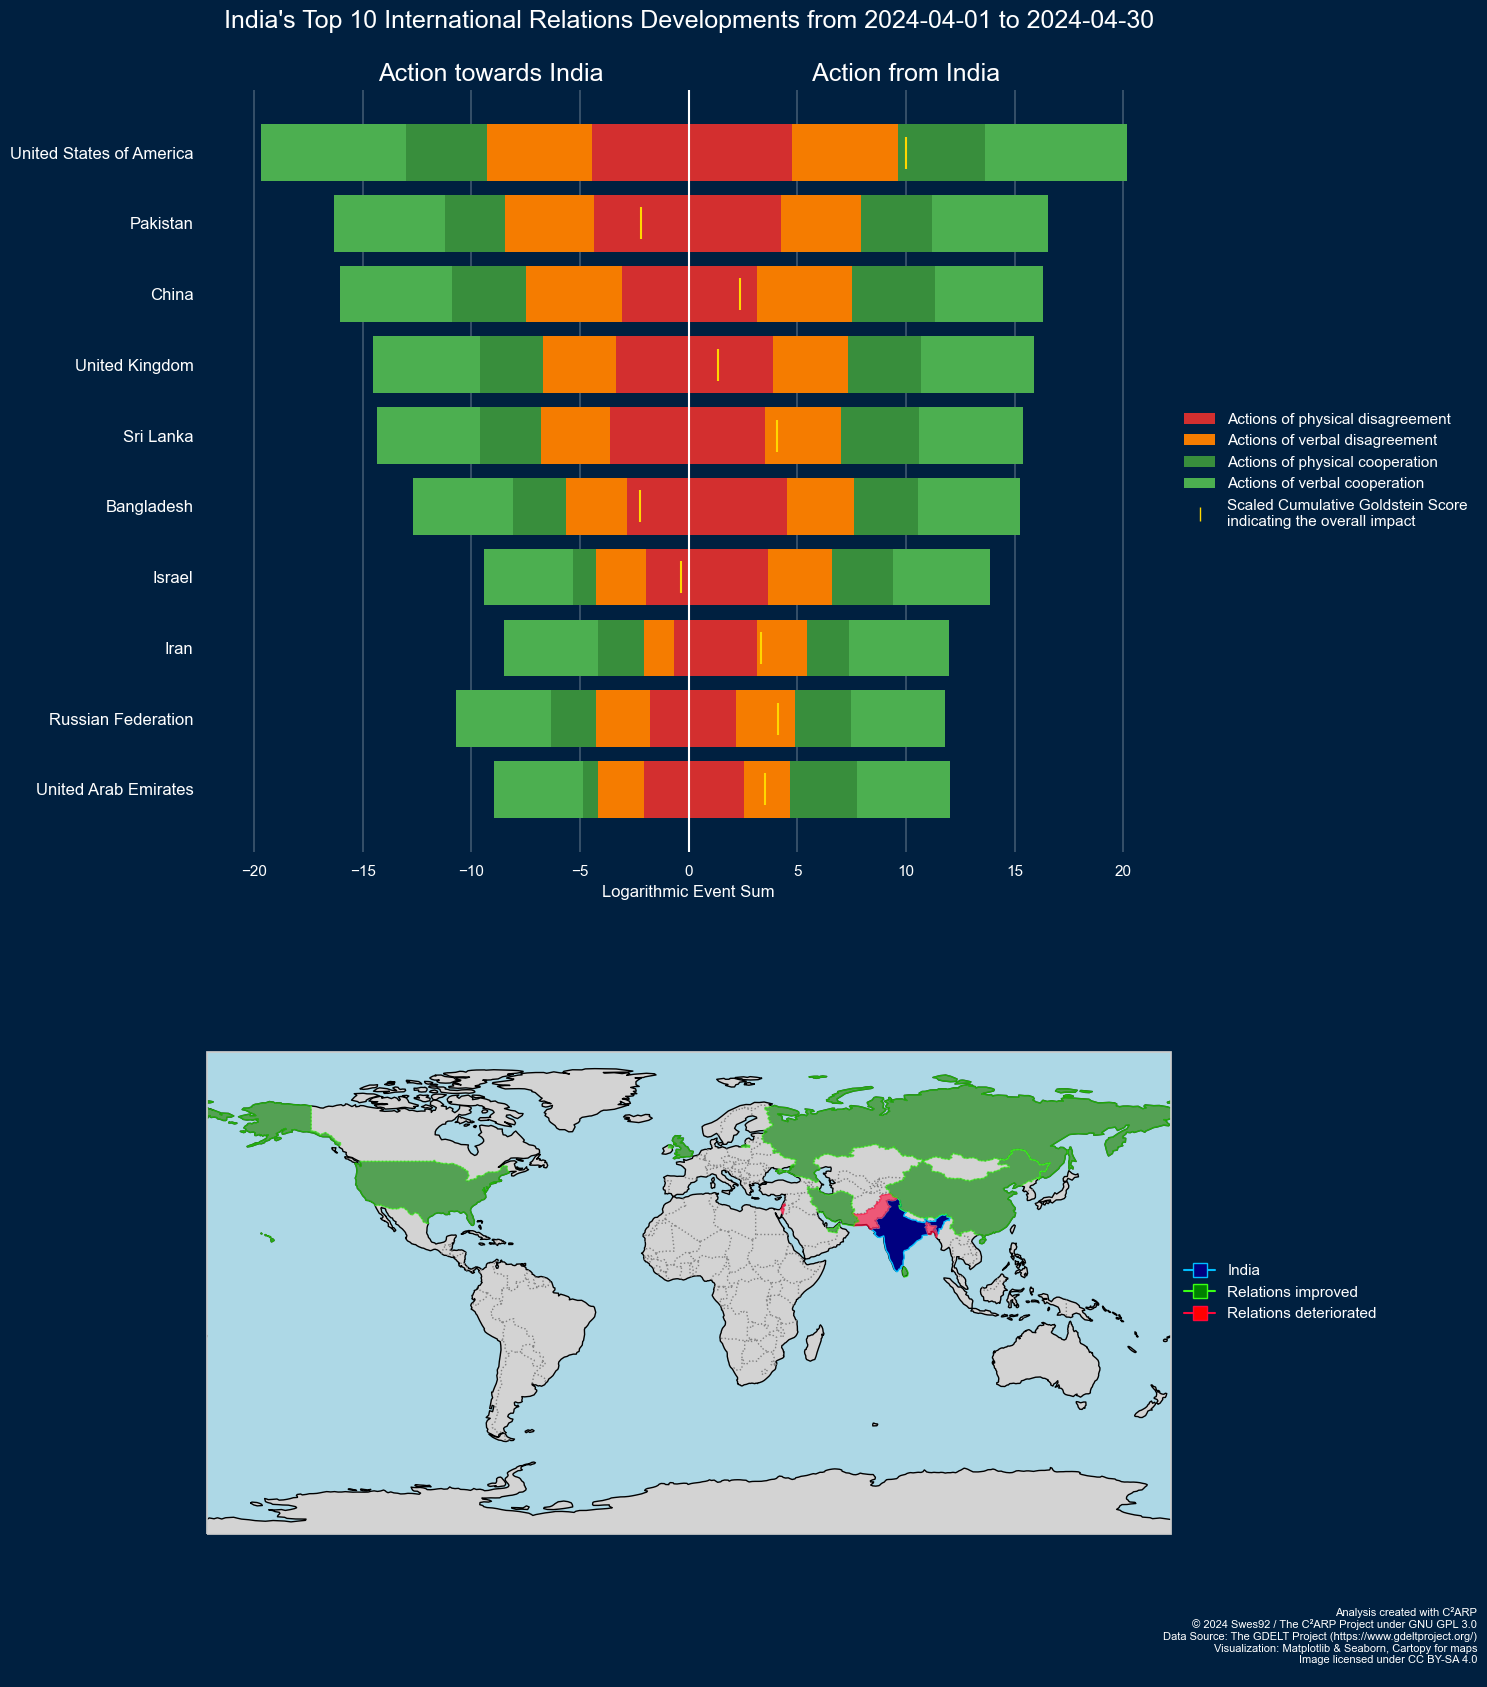

In [39]:
c2arp_actors_viz("IND_actors.csv", 'IND', '2024 04 01', '2024 04 30')

In [6]:
def c2arp_domestic(file, country):
    df = pd.read_csv(file, low_memory=False)
    print(df.head())

#testing
c2arp_domestic("IND_test.csv", 'IND')

   GLOBALEVENTID              SQLDATE  MonthYear  Year  FractionDate  \
0     1167054545  2024-04-01 00:00:00     202404  2024     2024.2493   
1     1167054548  2024-04-01 00:00:00     202404  2024     2024.2493   
2     1167054570  2024-04-01 00:00:00     202404  2024     2024.2493   
3     1167054571  2024-04-01 00:00:00     202404  2024     2024.2493   
4     1167054591  2024-04-01 00:00:00     202404  2024     2024.2493   

  Actor1Code Actor1Name Actor1CountryCode Actor1KnownGroupCode  \
0        NaN        NaN               NaN                  NaN   
1        NaN        NaN               NaN                  NaN   
2        NaN        NaN               NaN                  NaN   
3        NaN        NaN               NaN                  NaN   
4        NaN        NaN               NaN                  NaN   

  Actor1EthnicCode  ... ActionGeo_Type             ActionGeo_FullName  \
0              NaN  ...              4    Kolkata, West Bengal, India   
1              NaN  ... 